# Урок 6. Градиентный бустинг

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

In [2]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [3]:
from sklearn.datasets import load_diabetes

In [4]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [8]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    mse_train = mean_squared_error(y_train, train_prediction)

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    mse_test = mean_squared_error(y_test, test_prediction)

    return mse_train, mse_test

In [11]:
# Число деревьев в ансамбле
n_trees = 25

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.05

all_eta = []
all_mse_train = []
all_mse_test = []

while eta <= 0.5:
    all_eta.append(eta)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    all_mse_train.append(mse_train)
    all_mse_test.append(mse_test)
    eta += 0.05

print(all_mse_train, all_mse_test)

[2103.825428374197, 1356.3728316052907, 1160.3183304666686, 822.9548349927874, 724.6999711112796, 620.069530264813, 480.54637719869476, 478.69361633675504, 398.65020637573787, 412.71574181107525] [2993.4572220304362, 3210.037824305435, 3293.2184446790975, 3453.413378143705, 3796.3893338873004, 3478.3872645200763, 4202.457944591111, 4032.445709300567, 5577.896684393286, 5302.251461590757]


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [12]:
import matplotlib.pyplot as plt

In [13]:
def get_error_plot(all_eta, all_mse_train, all_mse_test):
    plt.xlabel('Step')
    plt.ylabel('MSE')
    plt.xlim(0.1, 0.5)
    plt.plot(all_eta, all_mse_train, label='train error')
    plt.plot(all_eta, all_mse_test, label='test error')
    plt.legend(loc='upper right')
    plt.show()

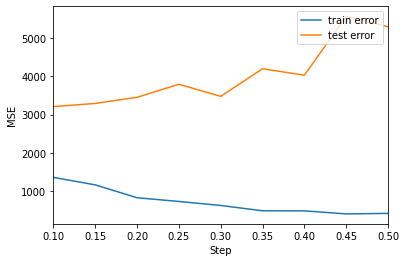

In [14]:
get_error_plot(all_eta, all_mse_train, all_mse_test)

In [ ]:
# Число деревьев в ансамбле
n_trees = 25

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 0.5

all_depth = []
all_mse_train = []
all_mse_test = []

while max_depth <= 20:
    all_depth.append(max_depth)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    all_mse_train.append(mse_train)
    all_mse_test.append(mse_test)
    max_depth += 1

print(all_mse_train, all_mse_test)

In [ ]:
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.xlim(1, 20)
plt.plot(all_depth, all_mse_train, label='train error')
plt.plot(all_depth, all_mse_test, label='test error')
plt.legend(loc='upper right')
plt.show()

## Домашние задания

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев при разных значениях шага градиента и для разной глубины деревьев. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [ ]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * predict(X, alg)[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [ ]:
class Reg_Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
def reg_quality(left_labels, right_labels, current_criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_criterion - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [ ]:
def reg_find_best_split(data, labels, min_leaf):

    current_criterion = np.var(data)
      
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
        
            current_quality = reg_quality(true_data, false_data, current_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
def reg_build_tree(data, labels, min_leaf=5, max_depth=None, depth=0, max_leaves=1000):
    
    quality, t, index = reg_find_best_split(data, labels, min_leaf)

    global counter_node
    global counter_leaf

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        counter_leaf += 1
        return Reg_Leaf(data, labels)

    if (max_depth is not None) and (depth >= max_depth):
        counter_leaf += 1
        return Reg_Leaf(data, labels)

    if max_leaves is not None:
        if counter_leaf <= max_leaves or counter_node <= (max_leaves/2):
              true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
              counter_node += 1
              depth += 1

    # Рекурсивно строим два поддерева
              true_branch = reg_build_tree(true_data, true_labels, 
                                     min_leaf, max_depth, depth, (max_leaves-counter_leaf))
              false_branch = reg_build_tree(false_data, false_labels, 
                                      min_leaf, max_depth, depth, (max_leaves-counter_leaf))
        elif (counter_leaf > max_leaves) or ((counter_node + 1) > (max_leaves / 2)):
              counter_leaf += 1
              return Reg_Leaf(data, labels)
        
    else:
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        counter_node += 1
        depth += 1 

        # Рекурсивно строим два поддерева
        true_branch = reg_build_tree(true_data, true_labels, 
                                 min_leaf, max_depth, depth, max_leaves)
        false_branch = reg_build_tree(false_data, false_labels, 
                                  min_leaf, max_depth, depth, max_leaves)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def mse (y, y_pred):
  return np.mean ((y - y_pred)**2)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Reg_Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
def reg_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    

    for i in range(n_trees):
        if len(trees) == 0:

            tree = reg_build_tree(X_train, y_train, min_leaf=5, max_depth=5, depth=0, max_leaves=1000)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree = reg_build_tree(X_train, bias(y_train, z_train), min_leaf=5, max_depth=5, depth=0, max_leaves=1000)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [ ]:
tree = reg_build_tree(X_train, y_train, min_leaf=5, max_depth=5, depth=0, max_leaves=1000)

In [ ]:
n_trees = 25
max_depth = 5
coefs = [1] * n_trees
eta = 0.5
counter_leaf = 0
counter_node = 0
trees, train_errors, test_errors = reg_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

In [ ]:
mse_train

In [ ]:
mse_test

In [ ]:
def grad_boost (X_train, y_train):
  count = 0 
  X_train_boost = []
  y_train_boost = []
  while count < (X_train.shape[0]//2):
      train_ind = np.random.randint(X_train.shape[0])
      X_train_boost.append(X_train[train_ind])
      y_train_boost.append(y_train[train_ind])
  return X_train_boost, y_train_boost

In [ ]:
def grad_boost_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            
            X_train_boost, y_train_boost = grad_boost (X_train, y_train)
            
            tree.fit(X_train_boost, y_train_boost)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            X_train_boost, y_train_boost = grad_boost (X_train, y_train)
            z_train = gb_predict(X_train_boost, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            X_train_boost, y_train_boost = grad_boost (X_train, y_train)
            tree.fit(X_train_boost, bias(y_train_boost, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [ ]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.05

grad_boost_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

In [ ]:
mse_train

In [ ]:
mse_test